In [1]:
import pandas as pd
import dask as dd

### Extract car industry entries

In [19]:
df = pd.read_csv('../data.csv')


/var/folders/5h/tc1b2dhx483_cx6pj09_pyc80000gn/T/ipykernel_55119/1484362809.py:1: DtypeWarning: Columns (3,4,7,8,11,12,14,15,16,19,45,46,49,56,69,83,95,98,99,100,104,108,109,119,120,121,122,123,124,125,127,128,129,141,143,144,145,146,147,148,155,188,217,218,219,220,221,222,223,224,226,229,232,233,234,235,236,237,238,239,240,243,244,245,246,248,249,250,252) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data.csv')


In [38]:
df = df[df['psic'].notna()] #drop 45 NaN participant SIC, fix the issue by not solving it
autoDF = df[df['psic'].str.contains('3711')] #Create df who have at least one participant in the automotive industry with SIC: 3711
autoDF.to_csv('autodf.csv') #create csv sample

## Work on car industry DF

In [2]:
autoDF = pd.read_csv('autodf.csv')

### Clean data

In [4]:
autoDF = autoDF.drop('Unnamed: 0.1', axis=1)
autoDF.rename(columns={"Unnamed: 0": "og_index"},inplace=True)

count    3683.000000
mean        2.315775
std         0.831181
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        13.000000
Name: nump, dtype: float64


<AxesSubplot:>

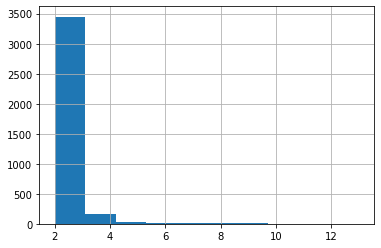

In [5]:
print(autoDF['nump'].describe())
autoDF['nump'].hist()

## H1: Auto industry incumbents tend to form alliances with new entrants introducing the EV technology rather than other incumbents

In [23]:
variables = ["id","activity", "activityc", "da", "jvinc", "jvindustry", "jvstatus", "p", "pbl", "pbuss", "psic", "nump"]

In [24]:
honeDF = autoDF[variables]
honeDF

,id,activity,activityc,da,jvinc,jvindustry,jvstatus,p,pbl,pbuss,psic,nump
0,23.0,Research & Development Services,RDS,01/01/86,NaN,NaN,Completed/Signed,General Motors Corp\nPenske Corp\nIlmor Engine...,"General Motors Corp, located\nin Detroit, Mich...",Mnfr motor vehicles\nWholesale industrial mach...,3711\n3714\n3728\n3812\n3761\n3577\n3579\n3661...,3.0
1,105.0,Manufacturing Services,MNF,02/03/86,AS,Transportation Equipment,Completed/Signed,General Motors Corp\nGutenhoffnungshuette,"General Motors Corp, located\nin Detroit, Mich...",Mnfr motor vehicles\nManufacture machinery,3711\n3714\n3728\n3812\n3761\n3577\n3579\n3661...,2.0
2,169.0,Manufacturing Services,MNF,03/24/86,AN,Machinery,Completed/Signed,General Motors Corp\nNihon Radiator Co Ltd,"General Motors Corp, located\nin Detroit, Mich...",Mnfr motor vehicles\nMnfr motor vehicle parts,3711\n3714\n3728\n3812\n3761\n3577\n3579\n3661...,2.0
3,196.0,Licensing Services\nManufacturing Services,LIC\nMNF,04/01/86,NaN,NaN,Completed/Signed,Hyundai Motor Co Ltd\nCincinnati Milacron Inc,"Hyundai Motor Co Ltd, located\nin Seoul, South...",Mnfr motor vehicles\nMnfr machine tool systems,3711\n3537\n3713\n7532\n3541\n3542\n3559\n3823...,2.0
4,238.0,Manufacturing Services,MNF,05/12/86,AS,Transportation Equipment,Pending,Bombardier Inc\nDaihatsu Motor Co,"Bombardier Inc, located in\nMontreal, Quebec, ...","Mnfr aircraft,railroad equip\nMnfr motor vehicles",3721\n3728\n3724\n3743\n7538\n8299\n5013\n5012...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3678,143287.0,Electrical & Electronic Services\nResearch & D...,EES\nRDS,12/18/15,AA,Construction Firms,Pending,Baic Motor Corp Ltd\nGuoxuan High-tech Co Ltd,"Baic Motor Corp Ltd, located\nin Beijing, Chin...",Automobile Manufacturing\nSwitchgear and Switc...,3711\n3713\n3715\n3792\n3613\n3629\n3612\n5063,2.0
3679,143293.0,Electric Utility Services,EUS,12/21/15,BF,"Electric, Gas, and Water Distribution",Pending,OOO Automotive Lighting\nFudi,Manufacture automotive\nlighting products\nCha...,Mnfr automotive lighting prod\nMnfr motor vehi...,3647\n3711\n3714,2.0
3680,143320.0,Oil and Gas; Petroleum Services,OGP,12/24/15,EC,Oil and Gas; Petroleum Refining,Pending,Andalas Energy & Power\nRiau Petroleum PT,"Andalas Energy & Power Plc ,\nlocated in Dougl...",Miscellaneous Intermediation\nManufacture moto...,6799\n3711\n3713\n3715\n3792,2.0
3681,143327.0,Manufacturing Services\nImport & Export (Tradi...,MNF\nIET,12/25/15,AV,Miscellaneous Manufacturing,Pending,Isuzu Motors Ltd\nSojitz Corp,"Isuzu Motors Ltd,\nheadquartered in Tokyo, Jap...","Mnfr,whl trucks,buses,engines\nDomestic,intl w...",3711\n3537\n5012\n3519\n3621\n3714\n5084\n5085...,2.0


In [20]:
autoDF


,og_index,id,_file,rdsp_de,rdsp_da,rddateeff,rddateann,rdjv_de,rdjvdate,hdate,...,rdsp_type,rdsp_typecode,rdsp_val,rdsp_valeff,rdma_stat,rdcomout,rdval,rdvaleff,n,jvdealno
0,23,23.0,Alliance SDC 1986.csv,NaN,NaN,NaN,NaN,NaN,NaN,01/01/86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GM/ILMOR/PENSKE CHEVY INDY V8 R&D AGMT.,2.187700e+08
1,105,105.0,Alliance SDC 1986.csv,NaN,NaN,NaN,NaN,NaN,NaN,02/03/86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GM/GUTENHOFFNUNGSHUETTE MILITARY ALL-TERRAIN ...,1.862980e+08
2,169,169.0,Alliance SDC 1986.csv,NaN,NaN,NaN,NaN,NaN,NaN,03/24/86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GM/NIHON CALSONIC HARRISON CO,1.857070e+08
3,196,196.0,Alliance SDC 1986.csv,NaN,NaN,NaN,NaN,NaN,NaN,04/01/86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI MILICRON/HYUNDAI MOTOR LIC. NC LATHES,2.169750e+08
4,238,238.0,Alliance SDC 1986.csv,NaN,NaN,NaN,NaN,NaN,NaN,05/12/86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VENUS CAR VENTURE,1.862900e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,143288,143287.0,Alliance SDC 2015.csv,NaN,NaN,NaN,NaN,NaN,NaN,12/18/15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BAIC MOTOR CORP LTD/GUOXUAN HIGH-TECH CO LTD-J...,2.935084e+09
3679,143294,143293.0,Alliance SDC 2015.csv,NaN,NaN,NaN,NaN,NaN,NaN,12/21/15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OOO AUTOMOTIVE LIGHTING /CHANGCHUN FUDI EQUIPM...,2.861884e+09
3680,143321,143320.0,Alliance SDC 2015.csv,NaN,NaN,NaN,NaN,NaN,NaN,12/24/15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANDALAS ENERGY & POWER PLC(WAS 1C9208)/RIAU PE...,2.891873e+09
3681,143328,143327.0,Alliance SDC 2015.csv,NaN,NaN,NaN,NaN,NaN,NaN,12/25/15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ISUZU MOTORS LTD/SOJITZ CORP-JOINT VENTURE,2.933704e+09


In [ ]:
adu